In [130]:
### import machine learning algorithms
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random

from datetime import datetime, timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

random.seed(8)

##### SELECT FEATURES AND LOAD DATASET

We being by loading the training dataset from the Kaggle Competition. Following which, we reserve 1% of the data for testing purposes. This is used to simulate unseen data and will be referenced later on

Here we select 1% of our data to be the "unseen" test data

In [193]:
train_df = pd.read_csv(r"./data_give_me_some_credit/cs-training.csv", low_memory=False, index_col=0)

### Next we split the training set into one for training and one for testing (unseen)
train_data = train_df.sample(frac=0.99, random_state=8)

### This test_data will be referenced later downstream
test_data = train_df.drop(train_data.index)
print(train_data.shape, test_data.shape)

### Reassign train_data back to train_df to minimize confusion
train_df = train_data

(148500, 11) (1500, 11)


In [194]:
train_data["SeriousDlqin2yrs"].value_counts()

0    138573
1      9927
Name: SeriousDlqin2yrs, dtype: int64

In [195]:
test_data["SeriousDlqin2yrs"].value_counts()

0    1401
1      99
Name: SeriousDlqin2yrs, dtype: int64

### Data Exploration and Preprocessing

Before we can conduct any machine learning or model training, we will first need to explore the data for any irregularities or insights. This section details a simple and straightforward visualization and preprocessing of data. There are 2 main aims here, to identify and understand how to handle outliers, and to identify and handle missing values. This step can be made more complex if necessary to improve model output.

The code that handles the processing logic for the outliers and missing values can be found further down in the **preprocess_data()** function.

**Note:** We perform data exploration on our train data and not our "unseen" test data, as we are not supposed to know what these values look like. 

**Age**

As we can see there is a wide distribution of age values. For simplicity, we will remove individuals under the age of 18 since this is regarding loans.

count    148500.000000
mean         52.296054
std          14.769448
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64


<AxesSubplot:xlabel='age', ylabel='Count'>

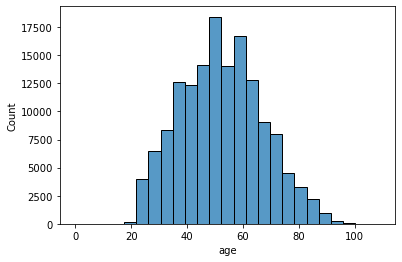

In [162]:
print(train_df.age.describe())
sns.histplot(data=train_df, x="age", bins=25)

**RevolvingUtilizationOfUnsecuredLines**

If we look at the description below, we can see that the RevolvingUtilizationOfUnsecuredLines variable has some very unusual and extreme values. That inflate the mean. As such, we will proceed to remove all values greater than the 99.8th percentile. Reason being, the 99.9th percentile has an extreme value of 1571.0 and so we use the 99.8th value

count    148500.000000
mean          6.060913
std         250.811816
min           0.000000
25%           0.029874
50%           0.154083
75%           0.558679
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
99.8th Percentile 2.716597074972116


<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='Count'>

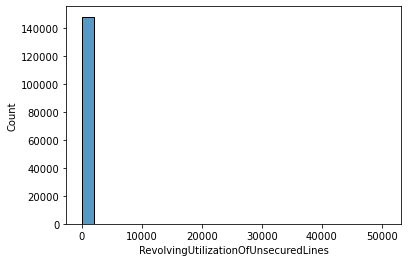

In [163]:
print(train_df["RevolvingUtilizationOfUnsecuredLines"].describe())

### Calculate nth-percentile
n = 99.8
print(f"{n}th Percentile", np.percentile(train_df["RevolvingUtilizationOfUnsecuredLines"], n))

sns.histplot(data=train_df, x="RevolvingUtilizationOfUnsecuredLines", bins=25)

**NumberOfTimes90DaysLate**

Here we can see that interestingly, there is nobody that is between 17 and 98 days late, but there are 264 people who are 98days late. While, this may seems strange, we do not want to remove these group of people as they may be severe defaulters. This is also not a concern if we are using a Random Forest model, as it is sensitive to outliers.

In [166]:
print(train_df.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count())
train_df[train_df['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

NumberOfTimes90DaysLate
0     140250
1       5188
2       1537
3        659
4        289
5        129
6         78
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       263
Name: NumberOfTimes90DaysLate, dtype: int64


,SeriousDlqin2yrs,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,268.000000,268.000000,268.000000,268.000000
mean,0.548507,97.962687,97.962687,97.962687
std,0.498573,0.271125,0.271125,0.271125
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


**NumberOfTime30-59DaysPastDueNotWorse**

Similarly, the NumberOfTime30-59DaysPastDueNotWorse variable has some very unusual and extreme values. Thus, what we will do is that we will remove all values that are greater than 3 standard deviations above the mean, and classify them as outliers. This value would be around 12-13, based on the description below.

count    148500.000000
mean          0.422182
std           4.205607
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64
0.42218181818181816
4.205607464199393


<AxesSubplot:xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='Count'>

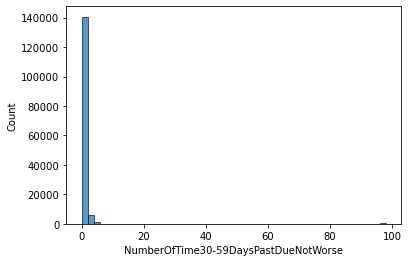

In [167]:
print(train_df["NumberOfTime30-59DaysPastDueNotWorse"].describe())

print(train_df["NumberOfTime30-59DaysPastDueNotWorse"].mean())
print(train_df["NumberOfTime30-59DaysPastDueNotWorse"].std())

sns.histplot(data=train_df, x="NumberOfTime30-59DaysPastDueNotWorse", bins=50)

**NumberOfTime60-89DaysPastDueNotWorse**

Here, the treatment is the same as the NumberOfTime30-59DaysPastDueNotWorse variable from the previous section. 

count    148500.000000
mean          0.241589
std           4.168274
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64
99.8th Percentile 5.002000000007683


<AxesSubplot:xlabel='NumberOfTime60-89DaysPastDueNotWorse', ylabel='Count'>

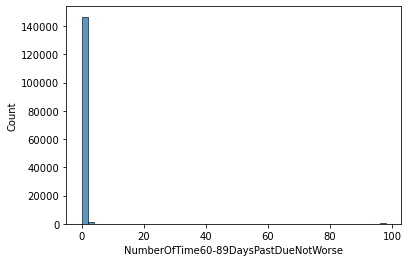

In [168]:
print(train_df["NumberOfTime60-89DaysPastDueNotWorse"].describe())

### Calculate nth-percentile
n = 99.8
print(f"{n}th Percentile", np.percentile(train_df["NumberOfTime60-89DaysPastDueNotWorse"], n))

sns.histplot(data=train_df, x="NumberOfTime60-89DaysPastDueNotWorse", bins=50)

**DebtRatio**

When we observe the debt ratio we can see that most of the values are less than 1. Here the definition of debt ratio is "Monthly debt payments, alimony, living costs divided by monthy gross income". Here we will remove values greater than the 97.5th percentile.

count    148500.000000
mean        353.136280
std        2044.668035
min           0.000000
25%           0.175206
50%           0.366655
75%           0.868495
max      329664.000000
Name: DebtRatio, dtype: float64
97.5th Percentile 3488.0


<AxesSubplot:xlabel='DebtRatio', ylabel='Count'>

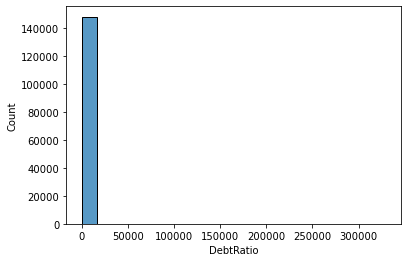

In [169]:
#print(train_df.loc[train_df["MonthlyIncome"].notnull()]["DebtRatio"].describe())
print(train_df["DebtRatio"].describe())

### Calculate nth-percentile
n = 97.5
print(f"{n}th Percentile", np.percentile(train_df["DebtRatio"], n))

sns.histplot(data=train_df, x="DebtRatio", bins=20)

##### HANDLING MISSING VALUES

In [170]:
### Count Number of Missing Values
train_df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29435
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3887
dtype: int64

**Monthly Income**

From the visualization below, we can see that the monthly income variable is heavily right skewed, which makes it difficult to impute with a constant value. 

5400.0


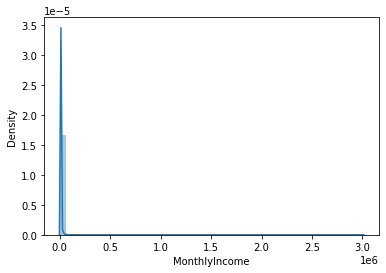

In [171]:
sns.distplot(train_df['MonthlyIncome'].dropna())
print(train_df["MonthlyIncome"].median())

**Number of Dependents**

As the number of dependents has a number of missing values. We will first visualize the data and decide how to handle the missing values. From our visualization, we can see that there the mode of the distribution is 0. As such, we can impute number of dependents as 0 if the value is missing. Furthermore, if someone leaves this column blank, it is likely that they have no dependents. 

0.0


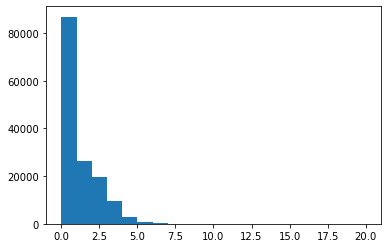

In [11]:
plt.hist(train_df['NumberOfDependents'], bins=20)
print(train_df["NumberOfDependents"].median())

##### DATASET UTILITY FUNCTIONS
Create a set of utility functions for use with the dataset, mainly for loading and preprocessing of train-validataion-test datasets

In [219]:
class Dataset:
    
    def __init__ (self, data, features, target):
        self.data = data.copy()
        self.features = features
        self.target = target


    def train_test_split(self, standardize=None):

        X = self.data[self.features]
        y = self.data[self.target]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=8,
            shuffle=True)
            
        if standardize:
            scale_params = {
                'minmax': MinMaxScaler(),
                'standard': StandardScaler()
            }
            dtypes= list(zip(X.dtypes.index, map(str, X.dtypes)))
            print(dtypes)
            for column, dtype in dtypes:
                if dtype == 'float32' or dtype == 'float64':

                    scaler = scale_params[standardize]
                    var = np.asarray(X_train[column]).reshape(-1,1)
                    scaler.fit(var)
                    print(f"Prior Mean: {X_train[column].mean()}")

                    X_train[column] = scaler.transform(np.asarray(X_train[column]).reshape(-1,1))
                    X_test[column] = scaler.transform(np.asarray(X_test[column]).reshape(-1,1))
                    print(f"Standardization method: {standardize}; Column Name: {column}")
                    print(f"Standardized Mean: {X_train[column].mean()}\n")
        else:
            print("Data standardization is not defined")


        print(f"X_train_shape:{X_train.shape}, y_train_shape:{y_train.shape}")
        print(f"X_test_shape:{X_test.shape}, y_test_shape:{y_test.shape}")

        return X_train.values, X_test.values, y_train.values, y_test.values


### FUNCTION TO PREPROCESS THE DATA FOR OUTLIERS AND MISSING VALUES
def preprocess_data(dataset, base_dataset):
    ### Preprocess Age
    age = 18
    dataset = dataset[dataset["age"] >= age]

    ### Preprocess RevolvingUtilizationOfUnsecuredLines
    n = 99.8
    percentile = np.percentile(base_dataset["RevolvingUtilizationOfUnsecuredLines"], n)
    dataset = dataset[dataset["RevolvingUtilizationOfUnsecuredLines"]<=percentile]

    ### Preprocess NumberOfTime30-59DaysPastDueNotWorse
    dpd59_mean = base_dataset["NumberOfTime30-59DaysPastDueNotWorse"].mean()
    dpd59_std = base_dataset["NumberOfTime30-59DaysPastDueNotWorse"].std()
    dpd59_cutoff = dpd59_mean + (dpd59_std * 3)
    dataset = dataset[dataset["NumberOfTime30-59DaysPastDueNotWorse"]<=dpd59_cutoff]

    ### Preprocess NumberOfTime60-89DaysPastDueNotWorse
    dpd89_mean = base_dataset["NumberOfTime60-89DaysPastDueNotWorse"].mean()
    dpd89_std = base_dataset["NumberOfTime60-89DaysPastDueNotWorse"].std()
    dpd89_cutoff = dpd89_mean + (dpd89_std * 3)
    dataset = dataset[dataset["NumberOfTime60-89DaysPastDueNotWorse"]<=dpd89_cutoff]

    ### Preprocess DebtRatio
    n = 97.5
    percentile_debt = np.percentile(base_dataset["DebtRatio"], n)
    dataset = dataset[dataset["DebtRatio"]<=percentile_debt]

    ### Fill NULL values with the median
    dataset = dataset.fillna(dataset.median())

    return dataset


### OVERSAMPLING - Function to divide the available data into two sets (strata)
def divide_data(data, target, interest_class):
    set_A = data.loc[data[target]==interest_class]
    set_B = data.loc[data[target]!=interest_class]
    assert interest_class not in set_B[target].unique()
    print(f"Set A size: {set_A.shape}, Set B size: {set_B.shape}\n")
    return set_A, set_B


### OVERSAMPLING - Function to construct the training set and the validation set
def oversample_train_test_split(coi_sample, other_sample, sample_amt=0.5):
    ratio = len(coi_sample)/len(other_sample)
    print(f"Original Ratio: {ratio}\n")

    ### Split Training Set - randomly select 50 per cent of the samples in set A
    coi_train, coi_val = train_test_split(coi_sample, test_size=sample_amt, random_state=1)
    print(f"{len(coi_train)} samples selected from Class of Interest Set A for training")

    ### Determine the Validation Size needed from Set_B
    other_samples_needed = (len(coi_val)/ratio)
    assert len(coi_val)/other_samples_needed == ratio
    print(f"Remainder from Set A: {len(coi_val)} - Number of Samples from Set B Needed: {int(other_samples_needed)}")

    ### Split the remaining set of other samples
    train_B, val_B = train_test_split(other_sample, train_size=len(coi_train), test_size=int(other_samples_needed), random_state=1)

    ### Construct Training Set
    train_data = pd.concat([coi_train, train_B], axis=0)
    assert train_data.shape[0] == coi_train.shape[0] + train_B.shape[0]
    print(f"Training Data Shape: {train_data.shape}\n")

    print(f"{len(coi_val)} samples from Set A's remainder and {len(val_B)} samples from remaining Set B were selected for validation")

    ### Construct Validation Set
    validation_data = pd.concat([coi_val, val_B], axis=0)
    assert validation_data.shape[0] == coi_val.shape[0] + val_B.shape[0]
    print(f"Validation Data Shape: {validation_data.shape}")

    val_ratio = len(coi_val)/len(val_B)
    print(f"Validataion Data Ratio: {round(val_ratio,3)}\n")

    return train_data, validation_data

##### FEATURE SELECTION
Select only the features to keep and drop the rest. Features that are kept are based on earlier data exploration. In this case, we have decided to keep all the features.

In [204]:
target=["SeriousDlqin2yrs"]
features = [x for x in train_df.columns if x != "SeriousDlqin2yrs"]

print(f"Features: {features}")

Features: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


##### DATA PROCESSING: GENERATE THE TRAIN-VALIDATION-TEST DATA AND PREPROCESS BEFORE TRAINING

**Training Data**

We split the training data into 2 datasets. A training set and a validation set. But before we do this, we will need to run our preprocess_data() function to preprocess the data

In [205]:
train_data = preprocess_data(dataset=train_data, base_dataset=train_df)

print("BEFORE PREPROCESSING:", train_data.shape)
print("AFTER PREPROCESSING:", train_data.shape)
#display(train_data.head())

BEFORE PREPROCESSING: (144229, 11)
AFTER PREPROCESSING: (144229, 11)


**Test Data**

Remember the "unseen" test data that we generated at the beginning? This dataset is not used for model training, as it represents our unseen data. Instead it is used for model testing, to give a better benchmark on how our model performs on unseen data. 

That said, we will still need to preprocess our test data, using the parameters that we know from our training data in the exploratory data analysis.

In [206]:
### Still need to preprocess the test data values using the training dataset as the reference
test_data = preprocess_data(dataset=test_data, base_dataset=train_df)

print("BEFORE PREPROCESSING:", test_data.shape)
print("AFTER PREPROCESSING:", test_data.shape)
#display(test_data.head())

BEFORE PREPROCESSING: (1463, 11)
AFTER PREPROCESSING: (1463, 11)


**Apply Oversampling**

As this is imbalanced dataset, what we can try to do is to apply oversampling to solve this issue. The code below will apply an oversampling algorithm to generate a training dataset and a validataion dataset. This can be used in place of the above train data if needed.

In [225]:
set_A, set_B = divide_data(train_data, target="SeriousDlqin2yrs", interest_class=1.)
train_data_os, validation_data_os = oversample_train_test_split(set_A, set_B, sample_amt=0.5)

X_train_os, y_train_os = train_data_os[features], train_data_os[target]
X_test_os, y_test_os = validation_data_os[features], validation_data_os[target]

Set A size: (9510, 11), Set B size: (134719, 11)

Original Ratio: 0.0705913790927783

4755 samples selected from Class of Interest Set A for training
Remainder from Set A: 4755 - Number of Samples from Set B Needed: 67359
Training Data Shape: (9510, 11)

4755 samples from Set A's remainder and 67359 samples from remaining Set B were selected for validation
Validation Data Shape: (72114, 11)
Validataion Data Ratio: 0.071



##### RANDOM FOREST CLASSIFIER MODEL CLASS

The code below is used to build a random forest classifier. It contains the Model Class, which is used for initiating the classifier model. A EvalMetrics Class, which is used to calculate the evaluation metrics for our model. Lastly, there is a train_and_evaluate() function that combines the Model and EvalMetrics Class to create a training and scoring pipeline

In [279]:
class Model:

    def __init__ (self, model_params=None):
        self.best_params_ = None
        self.model_params = model_params
        self.model = self.build()
    
    def build(self):
        if self.model_params is not None:
            model = RandomForestClassifier(**self.model_params, random_state=8)
        else:
            print("Model Parameters Not Specified - Initiating without Params")
            model = RandomForestClassifier(random_state=8)
        return model
    
    def gridsearch(self, X_train, y_train, grid_params):
        import warnings
        warnings.filterwarnings('ignore')
        from sklearn.metrics import make_scorer, average_precision_score
        
        scoring_metrics = {"auc": "roc_auc", "average_precision": make_scorer(average_precision_score)}
        classifier = GridSearchCV(
            estimator=self.model,
            param_grid=grid_params,
            scoring=scoring_metrics,
            refit="auc",
            cv=5,
            verbose=1,
            return_train_score=True
        )
        classifier.fit(X_train, y_train.ravel())
        print("\nBEST GRIDSEARCH PARAMETERS:", classifier.best_params_, classifier.best_estimator_)
        return classifier


class EvalMetrics:

    def __init__ (self, y_test, y_pred, y_pred_proba):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_proba = y_pred_proba
    
    def get_accuracy_score(self):
        acc_score = accuracy_score(self.y_test, self.y_pred)
        print(f"\nAccuracy Score: {round(acc_score, 5)}")
        return acc_score

    def get_roc_auc_score(self):
        roc_score = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        print(f"\nROC-AUC Score: {round(roc_score, 5)}")
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(self.y_test,  self.y_pred_proba[:,1])

        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        return roc_auc_score

    def get_classification_report(self):
        report = (
            classification_report(self.y_test, self.y_pred, target_names=["class 0", "class 1"], digits=3)
        )
        print(report)
        return report

    def get_confusion_matrix(self):
        cf_matrix = confusion_matrix(self.y_test, self.y_pred)
        tn, fp, fn, tp = cf_matrix.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        print(f"\nSensitivity Score: {round(sensitivity, 5)}")
        print(f"\nSpecificity Score: {round(specificity, 5)}")
        return cf_matrix


def train_and_evaluate(model, data, threshold=None):
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]
    model.fit(X_train, y_train)
    y_pred_proba=model.predict_proba(X_test)

    ### Define y_pred based on threshold sepcification
    if threshold is not None:
        y_pred = np.where(y_pred_proba[:,1] > threshold, 1., 0.)
        #y_pred=(model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    else:
        y_pred = model.predict(X_test)
    
    metrics = EvalMetrics(y_test, y_pred, y_pred_proba)
    classification_report = metrics.get_classification_report()
    accuracy_score = metrics.get_accuracy_score()
    cf_matrix = metrics.get_confusion_matrix()
    roc_auc_score = metrics.get_roc_auc_score()

    try:
        best_params = model.best_params_
        print(best_params)
    except:
        print("\nBest Params Attribute Unavailable")
    
    return model, metrics


### HYPERPARAMETER TUNING - GRIDSEARCH CV

Here we do a simple grid search for hyperparameter tuning. We begin by defining a hyperparameter grid for the search space. Following which, we use Scikit-Learn's gridsearch library to perform the grid search, and print out the best parameters.

In [136]:
### SET HYPERPARAMETER GRID SEARCH PARAMETERS HERE
grid_params = {
                "n_estimators": range(100,200,300),
                "max_depth": range(3, 9, 1),
                "min_samples_split": range(1, 8, 2),
                "max_leaf_nodes": range(1, 8, 2),
                "max_features":["log2", "sqrt"]
            }

##### INITIALIZE THE DATASET TO TUNE ON
target=["SeriousDlqin2yrs"]
features = [x for x in train_df.columns if x != "SeriousDlqin2yrs"]

TRAIN_DATA = Dataset(train_data.copy(), features, target)
X_train, X_test, y_train, y_test = TRAIN_DATA.train_test_split(standardize=None)
TRAIN_DATA = (X_train, X_test, y_train, y_test)

classifier_gridsearch = Model(model_params=None)
classifier_gridsearch = classifier_gridsearch.gridsearch(X_train, y_train, grid_params=grid_params)
#classifier_train = train_and_evaluate(classifier, TRAIN_DATA, get_proba=True)
print("End of Run - Gridsearch Complete")

Data standardization is not defined
X_train_shape:(104881, 10), y_train_shape:(104881, 1)
X_test_shape:(26221, 10), y_test_shape:(26221, 1)
Model Parameters Not Specified - Initiating without Params
Fitting 5 folds for each of 192 candidates, totalling 960 fits

BEST GRIDSEARCH PARAMETERS: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 7, 'min_samples_split': 3, 'n_estimators': 100} RandomForestClassifier(max_depth=3, max_features='log2', max_leaf_nodes=7,
                       min_samples_split=3, random_state=8)
End of Run - Gridsearch Complete


In [180]:
print("\nBEST GRIDSEARCH PARAMETERS:", classifier_gridsearch.best_params_, classifier_gridsearch.best_estimator_)


BEST GRIDSEARCH PARAMETERS: {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 7, 'min_samples_split': 3, 'n_estimators': 100} RandomForestClassifier(max_depth=3, max_features='log2', max_leaf_nodes=7,
                       min_samples_split=3, random_state=8)


### MODEL TRAINING - RANDOM FOREST CLASSIFIER MODEL

Here we train the Random Forest Classifier on the training data and not the holdout data. We begin by initiating our Random Forest Classifier using the best parameters that we got from hyperparameter tuning.

In the train_and_evaluate() function, we can see that there is a threshold value. This threshold value defines when we would classify an individual as a postive class (delinquent), by using the underlying predicted probabilities output.

Here, we set the threshold to any probability greater than 0.6 as the delinquent class (class 1). The reason for this is because we want to minimize the number of false positives, to truly identify bad actors. That said this threshold is flexible and can be defined based on requirements in the code.


In [308]:
THRESHOLD = 0.5

**MODEL TRAINING - TRAIN-VALIDATION DATA (train_data)**

Here we train our model using these steps:
1. Create the training and validation datasets from our train_data variable
2. Initiate a Random Forest Classifier Model using the best_params_ from our gridsearch earlier
3. Fit this model to our training set
4. Score and evaluate model performance on our validation set

Data standardization is not defined
X_train_shape:(115383, 10), y_train_shape:(115383, 1)
X_test_shape:(28846, 10), y_test_shape:(28846, 1)

EVALUATION ON TRAINING DATASET: (144229, 11)

              precision    recall  f1-score   support

     class 0      0.936     1.000     0.967     26973
     class 1      0.897     0.014     0.027      1873

    accuracy                          0.936     28846
   macro avg      0.916     0.507     0.497     28846
weighted avg      0.933     0.936     0.906     28846


Accuracy Score: 0.93587

Sensitivity Score: 0.01388

Specificity Score: 0.99989

ROC-AUC Score: 0.851


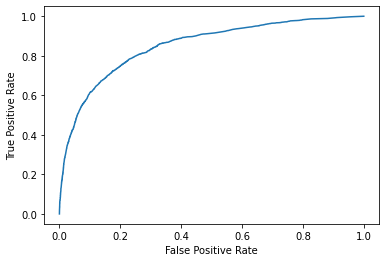


Best Params Attribute Unavailable


In [309]:
TRAIN_DATA = Dataset(train_data.copy(), features, target)
X_train, X_test, y_train, y_test = TRAIN_DATA.train_test_split(standardize=None)
TRAIN_DATA = (X_train, X_test, y_train, y_test)

### We use the best parameters from our gridsearch hyperparameter tuning
rf_model_params = classifier_gridsearch.best_params_

### TRAIN MODEL AND EVALUATE ON TRAINING DATASET
print(f"\nEVALUATION ON TRAINING DATASET: {train_data.shape}\n")

classifier = Model(model_params=rf_model_params).build()    
classifier_train, classifier_train_metrics = train_and_evaluate(
    classifier, TRAIN_DATA, threshold=THRESHOLD
) 

**MODEL TRAINING - TRAIN-VALIDATION (OVERSAMPLED DATA)**

Here we train our model using these steps:
1. Create the training and validation datasets using the **oversampled** datasets created earlier
2. Initiate a Random Forest Classifier Model using the best_params_ from our gridsearch earlier
3. Fit this model to our "oversampled" training set
4. Score and evaluate model performance on our "oversampled" validation set

X_train_shape:(9510, 10), y_train_shape:(9510, 1)
X_test_shape:(72114, 10), y_test_shape:(72114, 1)

EVALUATION ON OVERSAMPLED DATASET
              precision    recall  f1-score   support

     class 0      0.981     0.736     0.841     67359
     class 1      0.176     0.800     0.289      4755

    accuracy                          0.740     72114
   macro avg      0.579     0.768     0.565     72114
weighted avg      0.928     0.740     0.805     72114


Accuracy Score: 0.74012

Sensitivity Score: 0.79958

Specificity Score: 0.73592

ROC-AUC Score: 0.85023


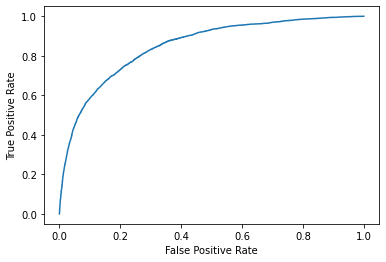


Best Params Attribute Unavailable


In [310]:
### We construct the same dataset but using the oversampled data
TRAIN_DATA_OS = (X_train_os, X_test_os, y_train_os, y_test_os)

print(f"X_train_shape:{X_train_os.shape}, y_train_shape:{y_train_os.shape}")
print(f"X_test_shape:{X_test_os.shape}, y_test_shape:{y_test_os.shape}")

### We use the same best parameters from our gridsearch hyperparameter tuning
rf_model_params = classifier_gridsearch.best_params_

### TRAIN MODEL AND EVALUATE ON TRAINING DATASET
print(f"\nEVALUATION ON OVERSAMPLED DATASET")

classifier = Model(model_params=rf_model_params).build()    
classifier_oversampled, classifier_os_metrics = train_and_evaluate(
    classifier, TRAIN_DATA_OS, threshold=THRESHOLD
) 

##### EVALUATE OUR TRAINED MODEL ON THE TEST SET

Here we will perform the following steps to see how our model performs on the "unseen" test data
1. Evaluate performance of "classifier_train" model that was trained using non-oversampled datasets
2. Evaluate performance of "classifier_oversampled" model that was trained using the oversampled datasets

In [311]:
def validate_model(model, test_data=test_data, threshold=None):
    X_val = test_data[features]
    y_val = test_data[target]

    y_val_pred_proba=model.predict_proba(X_val)

    ### Define y_pred based on threshold sepcification
    if threshold is not None:
        y_val_pred = np.where(y_val_pred_proba[:,1] > threshold, 1., 0.)
    else:
        y_val_pred = model.predict(X_val)
    
    val_metrics = EvalMetrics(y_val, y_val_pred, y_val_pred_proba)
    classification_report = val_metrics.get_classification_report()
    accuracy_score = val_metrics.get_accuracy_score()
    cf_matrix = val_metrics.get_confusion_matrix()
    roc_auc_score = val_metrics.get_roc_auc_score()
    
    return val_metrics

**"CLASSIFIER_TRAIN" MODEL EVALUATION ON "UNSEEN" TEST DATA**


EVALUATION OF "CLASSIFIER_TRAIN" MODEL ON "UNSEEN" TEST DATASET: (1463, 11)

              precision    recall  f1-score   support

     class 0      0.935     0.999     0.966      1367
     class 1      0.500     0.010     0.020        96

    accuracy                          0.934      1463
   macro avg      0.717     0.505     0.493      1463
weighted avg      0.906     0.934     0.904      1463


Accuracy Score: 0.93438

Sensitivity Score: 0.01042

Specificity Score: 0.99927

ROC-AUC Score: 0.85383


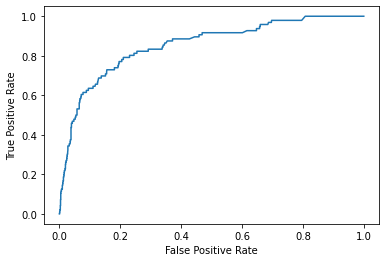

In [312]:
### TRAIN AND EVALUATE ON HOLDOUT DATASET
print(f"\nEVALUATION OF \"CLASSIFIER_TRAIN\" MODEL ON \"UNSEEN\" TEST DATASET: {test_data.shape}\n")

eval_metrics = validate_model(model=classifier_train, test_data=test_data, threshold=THRESHOLD)

**"CLASSIFIER_OVERSAMPLED" MODEL EVALUATION ON "UNSEEN" TEST DATA**


EVALUATION OF "CLASSIFIER_TRAIN" MODEL ON "UNSEEN" TEST DATASET: (1463, 11)

              precision    recall  f1-score   support

     class 0      0.981     0.740     0.843      1367
     class 1      0.176     0.792     0.288        96

    accuracy                          0.743      1463
   macro avg      0.578     0.766     0.566      1463
weighted avg      0.928     0.743     0.807      1463


Accuracy Score: 0.74299

Sensitivity Score: 0.79167

Specificity Score: 0.73958

ROC-AUC Score: 0.85814


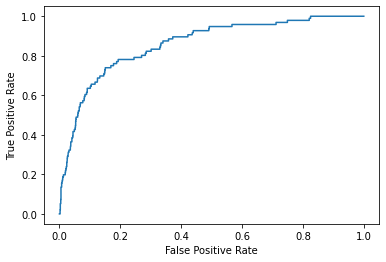

In [313]:
### TRAIN AND EVALUATE ON HOLDOUT DATASET
print(f"\nEVALUATION OF \"CLASSIFIER_TRAIN\" MODEL ON \"UNSEEN\" TEST DATASET: {test_data.shape}\n")

eval_metrics_os = validate_model(model=classifier_oversampled, test_data=test_data, threshold=THRESHOLD)

##### Visualize Random Forest Architecture

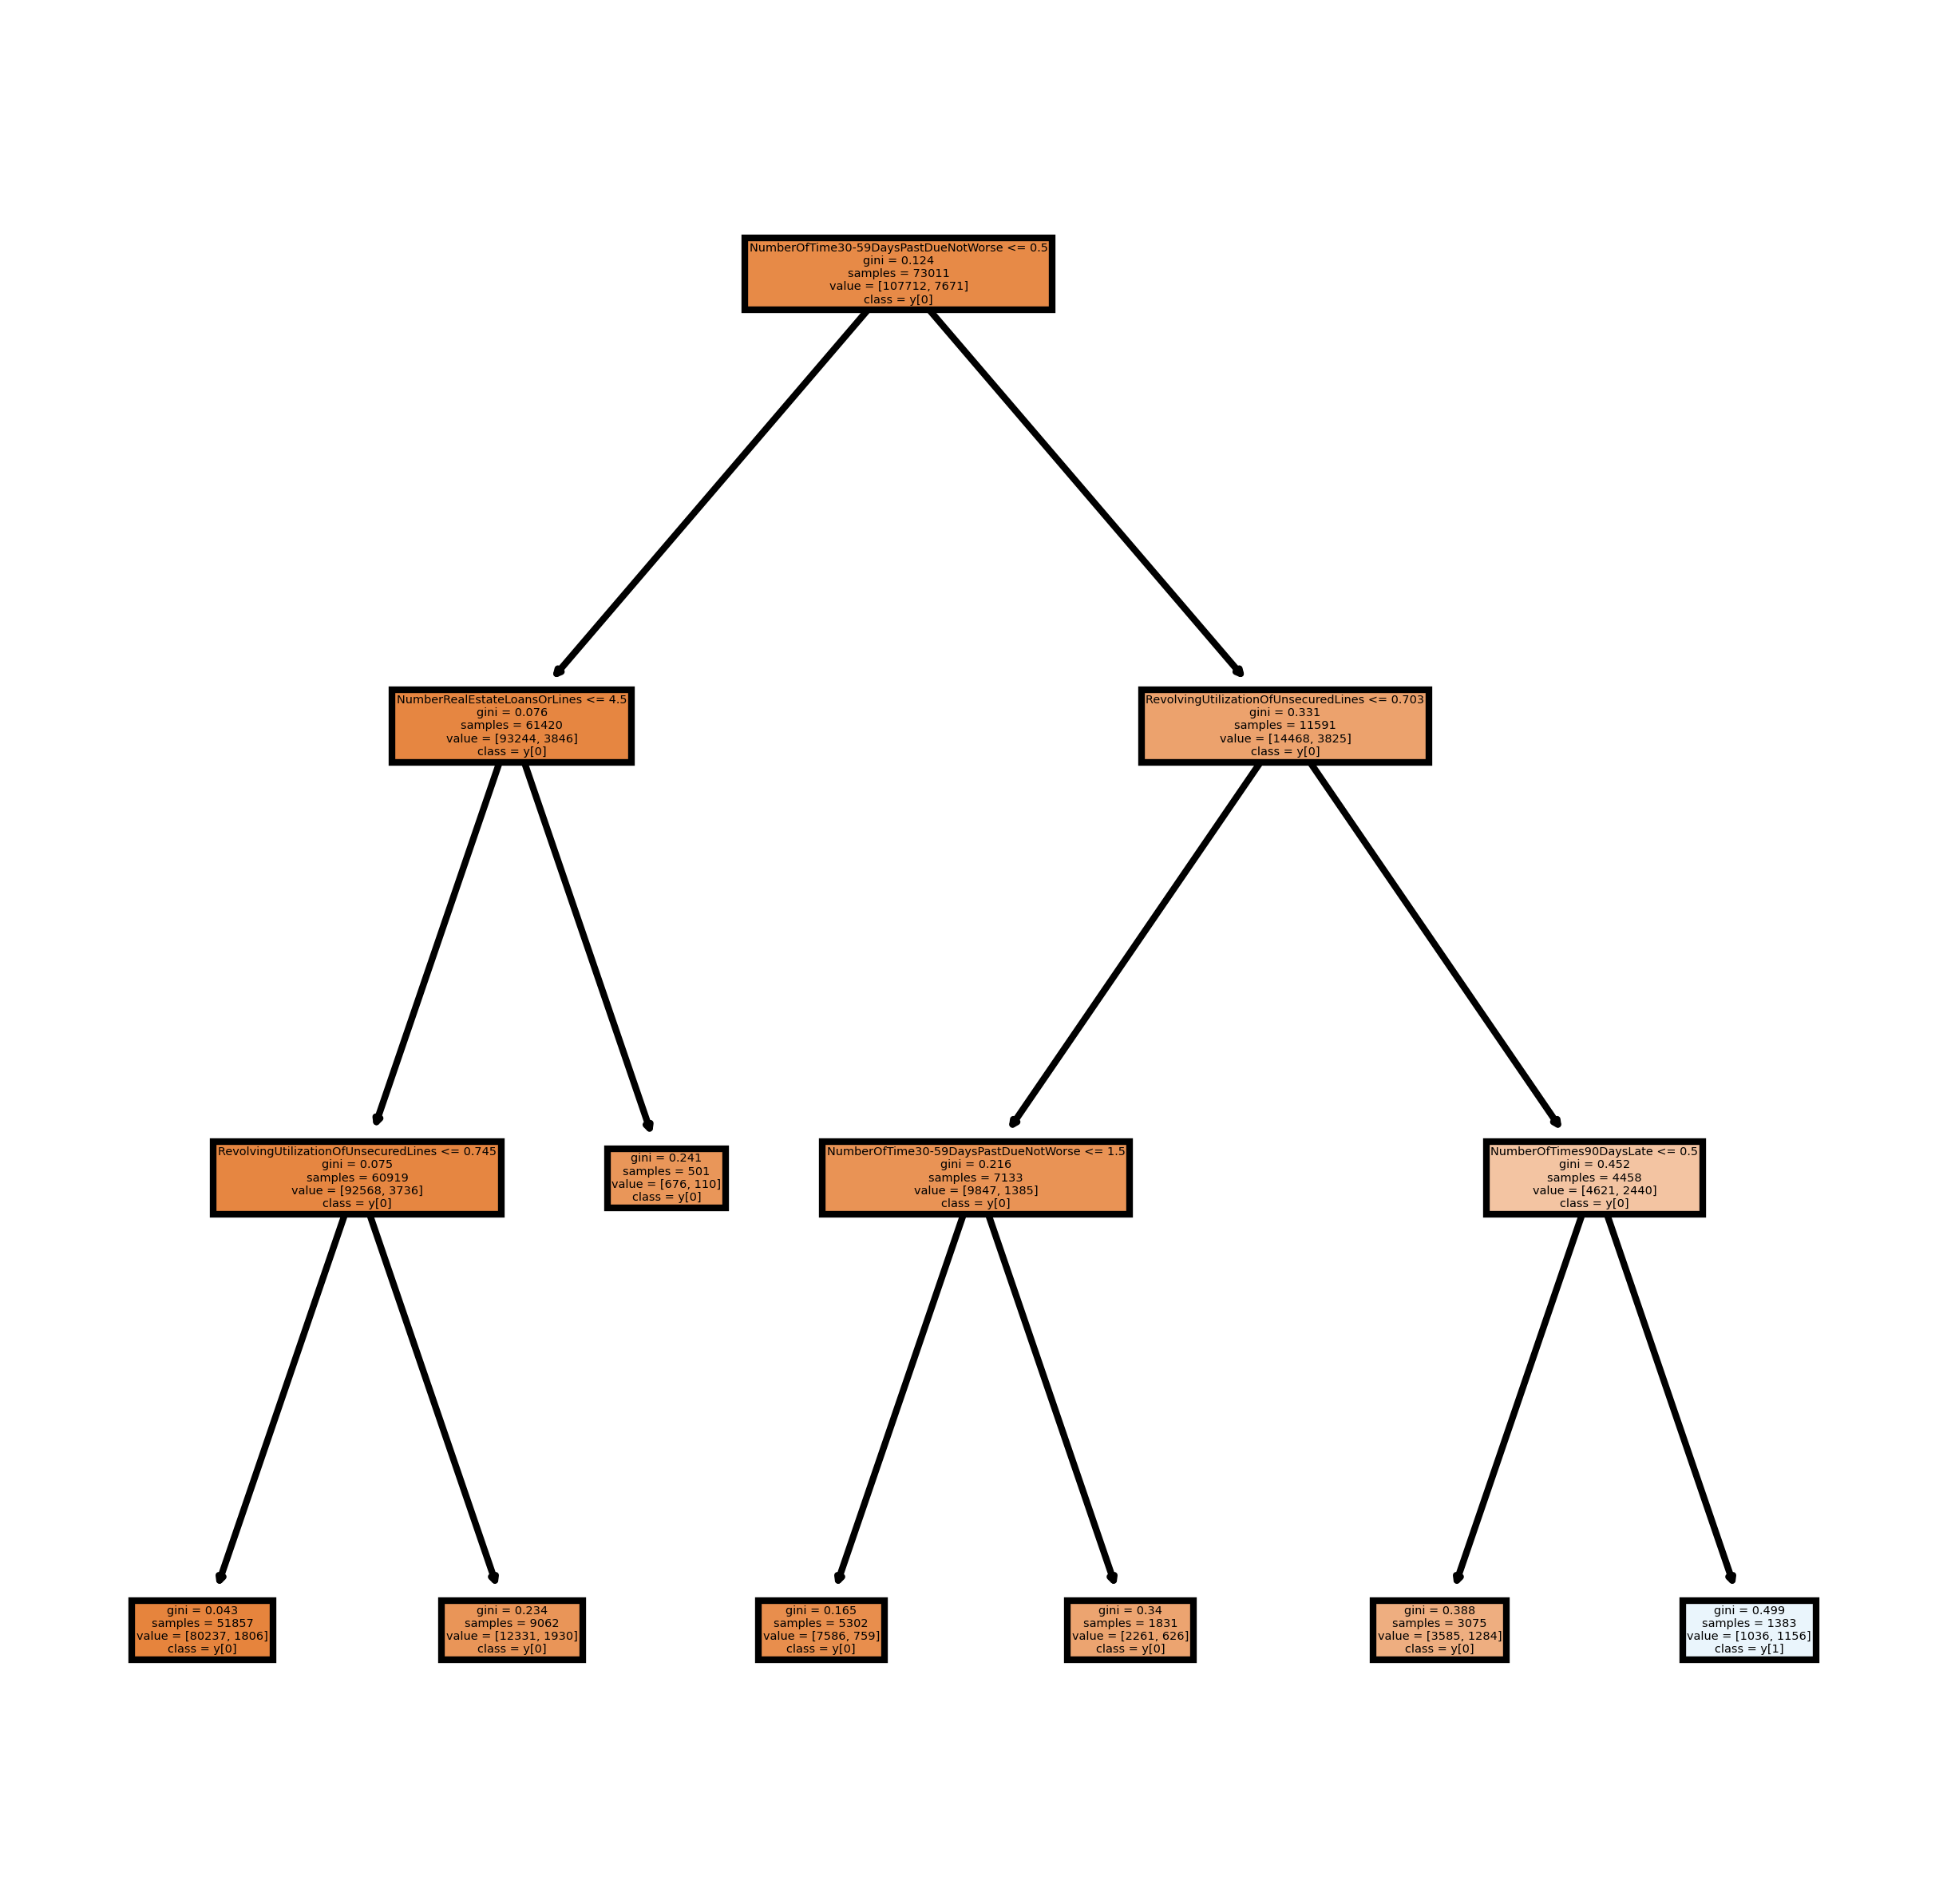

In [314]:
import os
from sklearn.tree import export_graphviz, plot_tree

# Export as dot file
estimator = classifier_train.estimators_[1]
fig, axes = plt.subplots(nrows = 1, ncols = 1,figsize = (5,5), dpi=600)
plot_tree(estimator,
        feature_names = features, 
        class_names=True,
        filled = True)
fig.savefig('rf_individualtree.png')